In [1]:
import os
import sys
import rootpath
sys.path.append(rootpath.detect())
import pickle
from testsuite.utilities import Pareto_split
import numpy as np
from testsuite.analysis import load_all, plot_all_pareto_2d, PLOT_STYLE, plot_measure
import matplotlib.pyplot as plt

In [2]:
dir_path = os.getcwd()
result_dirs = sorted(os.listdir("./log_data/"))
result_dirs

['test_function_Saf_Sms_init10_MultiSurrogate_mean',
 'test_function_Saf_init10_MultiSurrogate_ei',
 'test_function_Saf_init10_MultiSurrogate_mean',
 'test_function_SmsEgo_init10_MultiSurrogate_ei',
 'test_function_Sms_Saf_init10_MultiSurrogate_mean']

In [24]:
try:
    safsms_results = np.load("./npy_results/safsms_results.npy")
    saf_ei_results = np.load("./npy_results/saf_ei_results.npy")
    saf_mu_results = np.load("./npy_results/saf_mu_results.npy")
    sms_ei_results = np.load("./npy_results/sms_ei_results.npy")
    sms_mu_results = np.load("./npy_results/sms_mu_results.npy")
except:
    safsms_results = load_all(os.path.join(dir_path, "log_data/", result_dirs[0]))
    saf_ei_results = load_all(os.path.join(dir_path, "log_data/", result_dirs[1]))
    saf_mu_results = load_all(os.path.join(dir_path, "log_data/", result_dirs[2]))
    sms_ei_results = load_all(os.path.join(dir_path, "log_data/", result_dirs[3]))
    sms_mu_results = load_all(os.path.join(dir_path, "log_data/", result_dirs[4]))

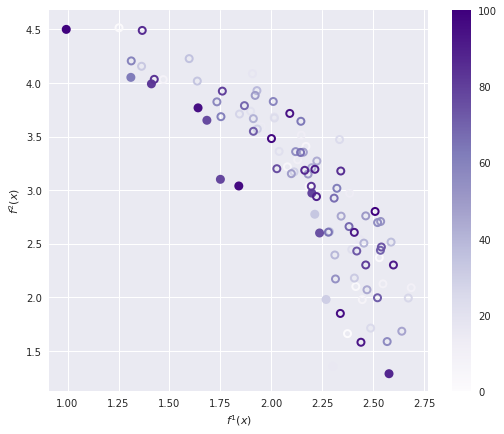

In [25]:
fig_smsmu = plot_all_pareto_2d(sms_mu_results, plot_indices=[0])

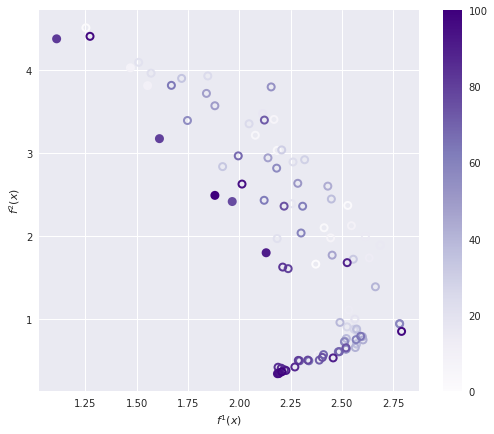

In [26]:
fig_smsmei= plot_all_pareto_2d(sms_ei_results, plot_indices=[0])

In [27]:
import wfg
N= 500

n_obj = 2                                   # Number of objectives
kfactor = 4
lfactor = 4

k = kfactor*(n_obj-1)   # position related params
l = lfactor*2           # distance related params
n_dim = k+l

func = wfg.WFG6


x_limits = np.zeros((2, n_dim))
x_limits[1] = np.array(range(1,n_dim+1))*2


args = [k, n_obj] # number of objectives as argument

y = np.zeros((N, n_obj))
for n in range(N):
    z = wfg.random_soln(k, l, func.__name__)
    y[n,:] = func(z, k, n_obj)

In [28]:
from pymoo.factory import get_performance_indicator

In [29]:
def extract_performance(z, indicator):
    ANS  = []
    for i in range(9, len(z)):
        p = Pareto_split(z[:i])[0]
        ans = indicator.calc(p)
        ANS.append(ans)

    return ANS

In [30]:
import lhsmdu
lhs_x =np.array(lhsmdu.sample(numDimensions=n_dim, numSamples=100)).T*x_limits[1]
lhs_y = np.array([func(z, k, n_obj) for z in lhs_x])
lhslhs_results = {"y": lhs_y,
                 "x": lhs_x}

In [31]:
ref = lhs_y.max(axis=0)
ref

array([2.71307637, 4.4737949 ])

In [32]:
igdp = get_performance_indicator("igd+", y)
hv = get_performance_indicator("hv", ref_point=ref)

In [33]:
lhslhs_results["n_initial"] = safsms_results['n_initial'][0]
lhslhs_results["hypervolume"] = hv.calc(lhslhs_results["y"])
lhslhs_results["igd"] = igdp.calc(lhslhs_results["y"])
print(lhslhs_results['hypervolume'])
print(lhslhs_results['igd'])
print(lhslhs_results['n_initial'])

2.1646566952951893
0.6288901856764012
10


In [34]:
safsms_results['igd'] = [extract_performance(safsms_results["y"][i], igdp) for i in range(len(safsms_results["y"]))][:2]
saf_ei_results['igd'] = [extract_performance(saf_ei_results["y"][i], igdp) for i in range(len(saf_ei_results["y"]))][:2]
saf_mu_results['igd'] = [extract_performance(saf_mu_results["y"][i], igdp) for i in range(len(saf_mu_results["y"]))][:2]
sms_ei_results['igd'] = [extract_performance(sms_ei_results["y"][i], igdp) for i in range(len(sms_ei_results["y"]))][:2]
sms_mu_results['igd'] = [extract_performance(sms_mu_results["y"][i], igdp) for i in range(len(sms_mu_results["y"]))][:2]

In [35]:
safsms_results['hypervolume'] = [extract_performance(safsms_results["y"][i], hv) for i in range(len(safsms_results["y"]))][:2]
saf_ei_results['hypervolume'] = [extract_performance(saf_ei_results["y"][i], hv) for i in range(len(saf_ei_results["y"]))][:2]
saf_mu_results['hypervolume'] = [extract_performance(saf_mu_results["y"][i], hv) for i in range(len(saf_mu_results["y"]))][:2]
sms_ei_results['hypervolume'] = [extract_performance(sms_ei_results["y"][i], hv) for i in range(len(sms_ei_results["y"]))][:2]
sms_mu_results['hypervolume'] = [extract_performance(sms_mu_results["y"][i], hv) for i in range(len(sms_mu_results["y"]))][:2]

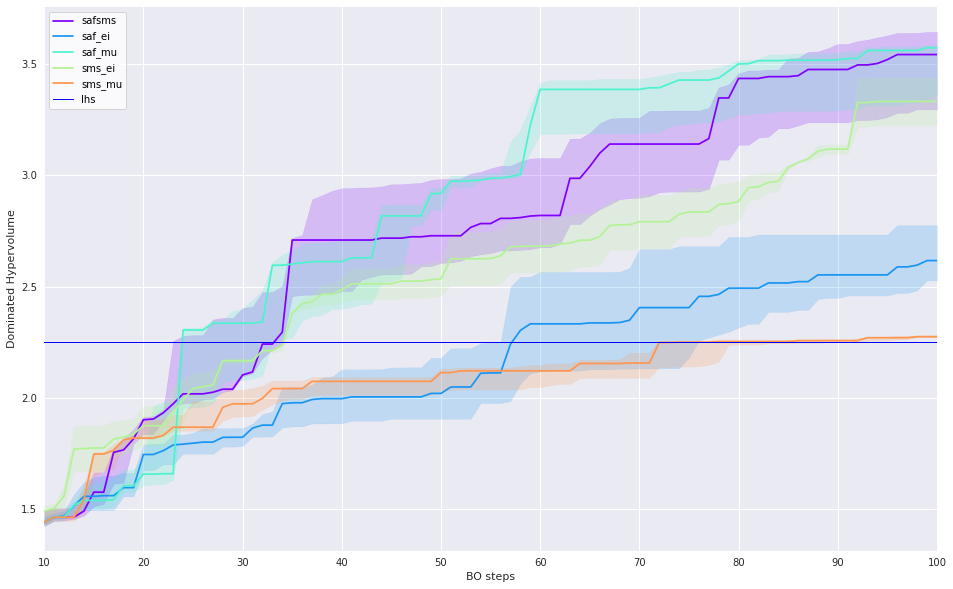

In [15]:
with plt.style.context(PLOT_STYLE["plot_style"]):
    fig_hv = plt.figure(figsize=[16, 10])
    ax_hv = fig_hv.gca()

cmap = PLOT_STYLE['plot_cmap']
colors = cmap(np.linspace(0, 1, len(result_dirs)+1))

plot_measure(safsms_results, measure="hypervolume", axis=ax_hv, plot_individuals=False, label="safsms", color=colors[0])
plot_measure(saf_ei_results, measure="hypervolume", axis=ax_hv, plot_individuals=False, label="saf_ei", color=colors[1])
plot_measure(saf_mu_results, measure="hypervolume", axis=ax_hv, plot_individuals=False, label="saf_mu", color=colors[2])
plot_measure(sms_ei_results, measure="hypervolume", axis=ax_hv, plot_individuals=False, label="sms_ei", color=colors[3])
plot_measure(sms_mu_results, measure="hypervolume", axis=ax_hv, plot_individuals=False, label="sms_mu", color=colors[4])
ax_hv.axhline(lhslhs_results["hypervolume"], linewidth=1, color="b", label="lhs")
# ax_hv.plot(range(10,101), q_result["hypervolume"], linewidth=1, color="r", label="q")
ax_hv.set_xlim([10, 100])
ax_hv.set_xlabel("BO steps")
ax_hv.set_ylabel("Dominated Hypervolume")
ax_hv.legend()

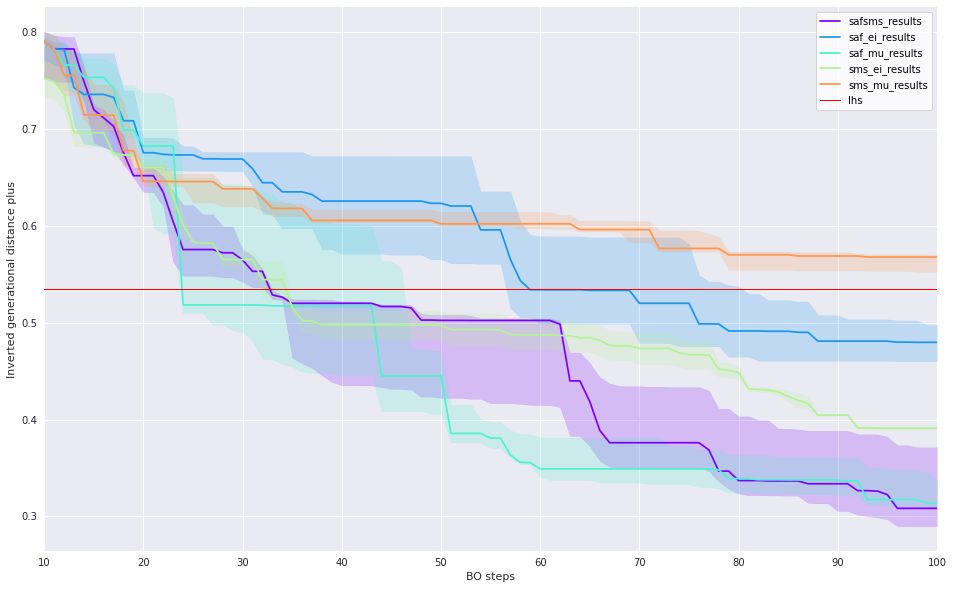

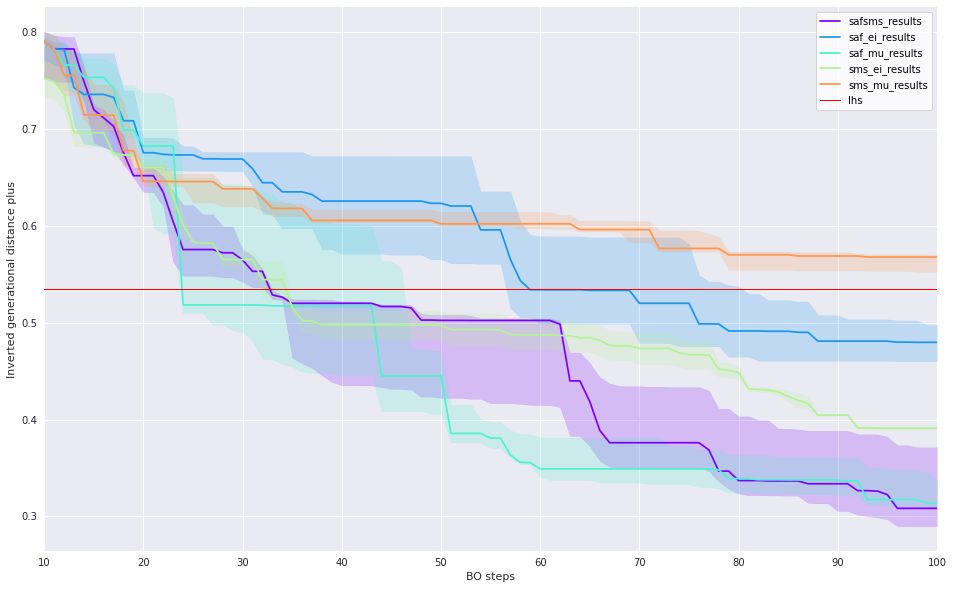

In [16]:
with plt.style.context(PLOT_STYLE["plot_style"]):
    fig_hv = plt.figure(figsize=[16, 10])
    ax_hv = fig_hv.gca()

cmap = PLOT_STYLE['plot_cmap']
colors = cmap(np.linspace(0, 1, len(result_dirs)+1))

plot_measure(safsms_results, measure="igd", axis=ax_hv, plot_individuals=False, label="safsms_results", color=colors[0])
plot_measure(saf_ei_results, measure="igd", axis=ax_hv, plot_individuals=False, label="saf_ei_results", color=colors[1])
plot_measure(saf_mu_results, measure="igd", axis=ax_hv, plot_individuals=False, label="saf_mu_results", color=colors[2])
plot_measure(sms_ei_results, measure="igd", axis=ax_hv, plot_individuals=False, label="sms_ei_results", color=colors[3])
plot_measure(sms_mu_results, measure="igd", axis=ax_hv, plot_individuals=False, label="sms_mu_results", color=colors[4])
ax_hv.axhline(lhslhs_results["igd"], linewidth=1, color="r", label="lhs")
# ax_hv.axhline(lhslhs_results["igd"][0], xmin=10, xmax=100, c=colors[7], label="lhs")

ax_hv.set_xlim([10, 100])
ax_hv.set_xlabel("BO steps")
ax_hv.set_ylabel("Inverted generational distance plus")
ax_hv.legend()
fig_hv

In [ ]:
np.save("./npy_results/safsaf_results", safsaf_results) 
np.save("./npy_results/safsms_results", safsms_results) 
np.save("./npy_results/saf_ei_results", saf_ei_results) 
np.save("./npy_results/saf_mu_results", saf_mu_results) 
np.save("./npy_results/sms_ei_results", sms_ei_results) 
np.save("./npy_results/sms_mu_results", sms_mu_results) 
np.save("./npy_results/smssaf_results", smssaf_results) 
np.save("./npy_results/lhslhs_results", lhslhs_results) 

In [18]:
hv.calc(lhslhs_results["y"])

2.2495474314686894

In [19]:
hv.calc(Pareto_split(lhslhs_results["y"])[0])

2.2495474314686894

In [37]:
results = [safsms_results,
          saf_ei_results,
          saf_mu_results,
          sms_ei_results,
          sms_mu_results]

In [44]:
ys = np.array([result["y"][:2]])

In [45]:
ys = ys.reshape(-1,2)

In [47]:
ys.max(axis=0)

array([2.81939078, 4.51562392])

In [48]:
ref

array([2.71307637, 4.4737949 ])